# Borrador de propuestas para proyecto 2 (JALR)

In [1]:
import pandas as pd
import numpy as np
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
import sys, os
sys.path.insert(0, os.path.abspath("../.."))

In [3]:
from src.utils.utils import load_df, save_df
from src.pipelines.feature_engineering import feature_generation, feature_selection, crea_timestamp

## Verificación de etapas pasadas

### Ingestión

In [4]:
ingestion_path = '../../output/ingest_df.pkl'
df_ingest = load_df(ingestion_path)
df_ingest.head()

,folio,fecha_creacion,hora_creacion,dia_semana,delegacion_inicio,incidente_c4,tipo_entrada,mes,label
0,GA/160123/05714,23/01/2016,22:35:04,Sábado,VENUSTIANO CARRANZA,accidente-choque sin lesionados,BOTÓN DE AUXILIO,1,0
1,AO/160123/05826,23/01/2016,22:50:49,Sábado,CUAJIMALPA,accidente-choque con lesionados,BOTÓN DE AUXILIO,1,0
2,C4/160124/02187,24/01/2016,09:40:11,Domingo,TLALPAN,accidente-choque sin lesionados,LLAMADA DEL 066,1,1
3,C4/160124/05723,24/01/2016,22:40:57,Domingo,MAGDALENA CONTRERAS,accidente-choque sin lesionados,LLAMADA DEL 066,1,1
4,C4/160124/01334,24/01/2016,04:25:15,Domingo,MIGUEL HIDALGO,accidente-choque sin lesionados,LLAMADA DEL 066,1,0


In [5]:
df_ingest.shape

(1383138, 9)

In [6]:
df_ingest.label.value_counts()

0    1100835
1     282303
Name: label, dtype: int64

Tenemos labels en todas las observaciones existentes.

In [7]:
df_ingest.delegacion_inicio.value_counts()

IZTAPALAPA             223687
GUSTAVO A. MADERO      144620
CUAUHTEMOC             141391
MIGUEL HIDALGO         115864
COYOACAN               110146
BENITO JUAREZ          104322
ALVARO OBREGON         102071
VENUSTIANO CARRANZA     94393
TLALPAN                 87339
AZCAPOTZALCO            60823
IZTACALCO               58567
XOCHIMILCO              52575
TLAHUAC                 33420
CUAJIMALPA              26714
MAGDALENA CONTRERAS     20062
MILPA ALTA               6986
Name: delegacion_inicio, dtype: int64

### Transformación de train

In [8]:
train_transformation_path = '../../output/transformation_df.pkl'
df_train_trans = load_df(train_transformation_path)
df_train_trans.head()

,fecha_creacion,hora_creacion,dia_semana,delegacion_inicio,incidente_c4,tipo_entrada,mes,label,sin_hr,cos_hr,sin_mes,cos_mes
1109067,2013-12-31,21:16:55,martes,cuauhtemoc,accidente-choque con lesionados,radio,1,0,-0.707107,0.707107,0.5,0.866025
372668,2013-12-31,23:45:27,martes,tlahuac,accidente-choque con lesionados,radio,1,0,-0.258819,0.965926,0.5,0.866025
1164288,2013-12-31,23:33:54,martes,cuauhtemoc,accidente-choque sin lesionados,llamada del 066,1,0,-0.258819,0.965926,0.5,0.866025
1109077,2013-12-31,23:53:50,martes,magdalena contreras,accidente-choque sin lesionados,llamada del 066,1,0,-0.258819,0.965926,0.5,0.866025
372686,2013-12-31,21:58:26,martes,iztapalapa,accidente-choque sin lesionados,llamada del 066,1,0,-0.707107,0.707107,0.5,0.866025


In [9]:
df_train_trans.shape

(968197, 12)

In [10]:
df_train_trans.label.value_counts()

0    766837
1    201360
Name: label, dtype: int64

Tenemos los labels en todas las observaciones requeridas para training.

### Transformación de test

Esto es antes de feature engineering.

In [11]:
test_path = '../../output/test_df.pkl'
df_test = load_df(test_path)
df_test.head()

,fecha_creacion,hora_creacion,dia_semana,delegacion_inicio,incidente_c4,tipo_entrada,mes,label,sin_hr,cos_hr,sin_mes,cos_mes
1251176,2018-10-19,20:57:10,viernes,alvaro obregon,accidente-choque sin lesionados,llamada del 911,10,0,-0.866025,0.500000,-0.866025,0.5
1251177,2018-10-19,14:52:28,viernes,benito juarez,accidente-choque sin lesionados,llamada del 911,10,0,-0.500000,-0.866025,-0.866025,0.5
1251163,2018-10-19,15:28:27,viernes,cuauhtemoc,accidente-choque sin lesionados,llamada del 911,10,0,-0.707107,-0.707107,-0.866025,0.5
1251178,2018-10-19,20:21:12,viernes,iztapalapa,accidente-choque con lesionados,llamada del 911,10,0,-0.866025,0.500000,-0.866025,0.5
1251146,2018-10-19,23:36:55,viernes,coyoacan,accidente-choque con lesionados,llamada del 911,10,0,-0.258819,0.965926,-0.866025,0.5


In [12]:
df_test.shape

(414941, 12)

In [13]:
df_test.label.value_counts()

0    333998
1     80943
Name: label, dtype: int64

Tenemos label en todas las observaciones necesarias.

### Train feature engineering

In [14]:
train_fe_path = '../../output/fe_df.pkl'
df_train = load_df(train_fe_path)
df_train = df_train.astype({'label':'category'})
df_train.head()

,alvaro_obregon,azcapotzalco,benito_juarez,coyoacan,cuajimalpa,cuauhtemoc,gustavo_a_madero,iztacalco,iztapalapa,magdalena_contreras,...,sin_hr,cos_hr,sin_mes,cos_mes,timestamp_creacion,tipo_dia,trimestre,sin_trim,cos_trim,llamada
0,0,0,0,0,0,1,0,0,0,0,...,-0.707107,0.707107,0.5,0.866025,2013-12-31 21:16:55,0,1,1,6.12323e-17,0
1,0,0,0,0,0,0,0,0,0,0,...,-0.258819,0.965926,0.5,0.866025,2013-12-31 23:45:27,0,1,1,6.12323e-17,0
2,0,0,0,0,0,1,0,0,0,0,...,-0.258819,0.965926,0.5,0.866025,2013-12-31 23:33:54,0,1,1,6.12323e-17,1
3,0,0,0,0,0,0,0,0,0,1,...,-0.258819,0.965926,0.5,0.866025,2013-12-31 23:53:50,0,1,1,6.12323e-17,1
4,0,0,0,0,0,0,0,0,1,0,...,-0.707107,0.707107,0.5,0.866025,2013-12-31 21:58:26,0,1,1,6.12323e-17,1


In [15]:
df_train.shape

(968197, 37)

In [16]:
df_train.label.value_counts()

0    766837
1    201360
Name: label, dtype: int64

In [17]:
201360 / (766837 + 201360)

0.20797420359699523

### Test feature engineering

In [18]:
test_fe_path = '../../output/test_fe_df.pkl'
df_test = load_df(test_fe_path)
df_test = df_test.astype({'label':'category'})
df_test.head()

,alvaro_obregon,azcapotzalco,benito_juarez,coyoacan,cuajimalpa,cuauhtemoc,gustavo_a_madero,iztacalco,iztapalapa,magdalena_contreras,...,sin_hr,cos_hr,sin_mes,cos_mes,timestamp_creacion,tipo_dia,trimestre,sin_trim,cos_trim,llamada
0,1,0,0,0,0,0,0,0,0,0,...,-0.866025,0.5,-0.866025,0.5,2018-10-19 20:57:10,1,4,-2.44929e-16,1,1
1,0,0,1,0,0,0,0,0,0,0,...,-0.5,-0.866025,-0.866025,0.5,2018-10-19 14:52:28,1,4,-2.44929e-16,1,1
2,0,0,0,0,0,1,0,0,0,0,...,-0.707107,-0.707107,-0.866025,0.5,2018-10-19 15:28:27,1,4,-2.44929e-16,1,1
3,0,0,0,0,0,0,0,0,1,0,...,-0.866025,0.5,-0.866025,0.5,2018-10-19 20:21:12,1,4,-2.44929e-16,1,1
4,0,0,0,1,0,0,0,0,0,0,...,-0.258819,0.965926,-0.866025,0.5,2018-10-19 23:36:55,1,4,-2.44929e-16,1,1


In [19]:
df_test.shape

(414941, 37)

In [20]:
df_test.label.value_counts()

0    333998
1     80943
Name: label, dtype: int64

## Modelado

Genera un maginc loop con los siguientes dos algoritmos cada uno modificando al menos 2 hiperparámetros con al menos 3 configuraciones diferentes y utilizando un CV de 5 a través de un `GridSearchCV`. El criterio de selección del mejor modelo será la eficiencia del modelo:

* `DecisionTree`
* `RandomForest`

In [21]:
df_train = df_train.sort_values('timestamp_creacion', ascending=True, ignore_index=True)
df_train.head()

,alvaro_obregon,azcapotzalco,benito_juarez,coyoacan,cuajimalpa,cuauhtemoc,gustavo_a_madero,iztacalco,iztapalapa,magdalena_contreras,...,sin_hr,cos_hr,sin_mes,cos_mes,timestamp_creacion,tipo_dia,trimestre,sin_trim,cos_trim,llamada
0,0,0,0,0,0,0,1,0,0,0,...,-0.258819,-0.965926,0.5,0.866025,2013-12-31 13:01:33,0,1,1,6.12323e-17,1
1,0,0,1,0,0,0,0,0,0,0,...,-0.258819,-0.965926,0.5,0.866025,2013-12-31 13:53:09,0,1,1,6.12323e-17,1
2,0,0,1,0,0,0,0,0,0,0,...,-0.258819,-0.965926,0.5,0.866025,2013-12-31 13:53:24,0,1,1,6.12323e-17,1
3,1,0,0,0,0,0,0,0,0,0,...,-1,-1.83697e-16,0.5,0.866025,2013-12-31 18:21:47,0,1,1,6.12323e-17,1
4,0,1,0,0,0,0,0,0,0,0,...,-0.965926,0.258819,0.5,0.866025,2013-12-31 19:02:13,0,1,1,6.12323e-17,1


In [22]:
df_train.shape[1]

37

In [23]:
df_test = df_test.sort_values('timestamp_creacion', ascending=True, ignore_index=True)
df_test.head()

,alvaro_obregon,azcapotzalco,benito_juarez,coyoacan,cuajimalpa,cuauhtemoc,gustavo_a_madero,iztacalco,iztapalapa,magdalena_contreras,...,sin_hr,cos_hr,sin_mes,cos_mes,timestamp_creacion,tipo_dia,trimestre,sin_trim,cos_trim,llamada
0,0,0,0,0,0,0,0,0,0,0,...,0,1,-0.866025,0.5,2018-10-19 00:02:01,1,4,-2.44929e-16,1,1
1,0,0,0,0,0,1,0,0,0,0,...,0,1,-0.866025,0.5,2018-10-19 00:12:45,1,4,-2.44929e-16,1,1
2,0,0,0,1,0,0,0,0,0,0,...,0,1,-0.866025,0.5,2018-10-19 00:18:43,1,4,-2.44929e-16,1,1
3,0,0,0,1,0,0,0,0,0,0,...,0,1,-0.866025,0.5,2018-10-19 00:18:52,1,4,-2.44929e-16,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,-0.866025,0.5,2018-10-19 00:29:13,1,4,-2.44929e-16,1,0


In [24]:
df_test.shape[1]

37

In [25]:
df_train.columns

Index(['alvaro_obregon', 'azcapotzalco', 'benito_juarez', 'coyoacan',
       'cuajimalpa', 'cuauhtemoc', 'gustavo_a_madero', 'iztacalco',
       'iztapalapa', 'magdalena_contreras', 'miguel_hidalgo', 'milpa_alta',
       'tlahuac', 'tlalpan', 'venustiano_carranza', 'xochimilco', 'accidente',
       'cadaver', 'detencion_ciudadana', 'lesionado', 'sismo',
       'fecha_creacion', 'hora_creacion', 'dia_semana', 'tipo_entrada', 'mes',
       'label', 'sin_hr', 'cos_hr', 'sin_mes', 'cos_mes', 'timestamp_creacion',
       'tipo_dia', 'trimestre', 'sin_trim', 'cos_trim', 'llamada'],
      dtype='object')

In [26]:
# features seleccionados en proyecto 1
features = ['accidente', 'cadaver', 'detencion_ciudadana', 'lesionado', 'sismo', 'llamada']
features += ['tipo_dia', 'sin_hr', 'cos_hr', 'sin_mes', 'cos_mes']
features

['accidente',
 'cadaver',
 'detencion_ciudadana',
 'lesionado',
 'sismo',
 'llamada',
 'tipo_dia',
 'sin_hr',
 'cos_hr',
 'sin_mes',
 'cos_mes']

In [27]:
x_train = df_train[features]
x_test = df_test[features]

y_train = df_train['label']
y_test = df_test['label']

In [28]:
x_train.head()

,accidente,cadaver,detencion_ciudadana,lesionado,sismo,llamada,tipo_dia,sin_hr,cos_hr,sin_mes,cos_mes
0,0,0,0,1,0,1,0,-0.258819,-0.965926,0.5,0.866025
1,1,0,0,0,0,1,0,-0.258819,-0.965926,0.5,0.866025
2,1,0,0,0,0,1,0,-0.258819,-0.965926,0.5,0.866025
3,1,0,0,0,0,1,0,-1,-1.83697e-16,0.5,0.866025
4,1,0,0,0,0,1,0,-0.965926,0.258819,0.5,0.866025


In [29]:
x_test.head()

,accidente,cadaver,detencion_ciudadana,lesionado,sismo,llamada,tipo_dia,sin_hr,cos_hr,sin_mes,cos_mes
0,1,0,0,0,0,1,1,0,1,-0.866025,0.5
1,1,0,0,0,0,1,1,0,1,-0.866025,0.5
2,1,0,0,0,0,1,1,0,1,-0.866025,0.5
3,1,0,0,0,0,1,1,0,1,-0.866025,0.5
4,1,0,0,0,0,0,1,0,1,-0.866025,0.5


In [30]:
y_train.head()

0    0
1    0
2    0
3    1
4    0
Name: label, dtype: category
Categories (2, int64): [0, 1]

In [31]:
y_test.head()

0    0
1    0
2    0
3    0
4    1
Name: label, dtype: category
Categories (2, int64): [0, 1]

### Magic Loop

In [32]:
algorithms_dict = {
    'tree': 'tree_grid_search',
    'random_forest': 'rf_grid_search',
    'logistic_regression': 'logistic_regression_grid_search'
}

In [33]:
grid_search_dict = {
    'tree_grid_search': {
        'max_depth': [15, 20, 25],
        'min_samples_leaf': [3, 5, 7]
    }, 
    'rf_grid_search': {
        'n_estimators': [100, 300, 500],
        'max_depth': [5, 10, 15],
        'min_samples_leaf': [6, 8, 10]
    },
    'logistic_regression_grid_search': {
        'penalty': ['l1', 'l2', 'none']
    }
}

In [34]:
estimators_dict = {
    'tree': DecisionTreeClassifier(random_state=2004),
    'random_forest': RandomForestClassifier(oob_score=True, random_state=2222),
    'logistic_regression': LogisticRegression(random_state=1711)
}

In [35]:
def magic_loop(algorithms, features, labels):
    best_estimators = []
    
    for algorithm in algorithms:
        estimator = estimators_dict[algorithm]
        grid_search_to_look = algorithms_dict[algorithm]
        grid_params = grid_search_dict[grid_search_to_look]
        
        tscv = TimeSeriesSplit(n_splits=5)
        gs = GridSearchCV(estimator, grid_params, scoring='average_precision', 
                          return_train_score=True, cv=tscv, n_jobs=-1)
        
        #train
        gs.fit(features, labels)
        #best estimator
        best_estimators.append(gs)
        
        
    return best_estimators

In [36]:
algorithms = ['tree', 'random_forest', 'logistic_regression']

In [37]:
best = magic_loop(algorithms, x_train, y_train)

In [38]:
best_tree = best[0].best_estimator_
best_tree

DecisionTreeClassifier(max_depth=15, min_samples_leaf=7, random_state=2004)

In [39]:
best_forest = best[1].best_estimator_
best_forest

RandomForestClassifier(max_depth=10, min_samples_leaf=8, n_estimators=300,
                       oob_score=True, random_state=2222)

In [143]:
best_logistic = best[2].best_estimator_
best_logistic

LogisticRegression(random_state=1711)

### Precisión

In [144]:
tree_predicted_scores = best_tree.predict_proba(x_test)
tree_predicted_scores[:10]

array([[0.79605911, 0.20394089],
       [0.79605911, 0.20394089],
       [0.79605911, 0.20394089],
       [0.79605911, 0.20394089],
       [0.96111111, 0.03888889],
       [0.79605911, 0.20394089],
       [0.79605911, 0.20394089],
       [0.79605911, 0.20394089],
       [0.78571429, 0.21428571],
       [0.78571429, 0.21428571]])

In [145]:
forest_predicted_scores = best_forest.predict_proba(x_test)
forest_predicted_scores[:10]

array([[0.79568732, 0.20431268],
       [0.79568732, 0.20431268],
       [0.79568732, 0.20431268],
       [0.79568732, 0.20431268],
       [0.95012177, 0.04987823],
       [0.79568732, 0.20431268],
       [0.79568732, 0.20431268],
       [0.79568732, 0.20431268],
       [0.83940162, 0.16059838],
       [0.83940162, 0.16059838]])

In [146]:
logistic_predicted_scores = best_logistic.predict_proba(x_test)
logistic_predicted_scores[:10]

array([[0.75751002, 0.24248998],
       [0.75751002, 0.24248998],
       [0.75751002, 0.24248998],
       [0.75751002, 0.24248998],
       [0.93764078, 0.06235922],
       [0.75751002, 0.24248998],
       [0.75751002, 0.24248998],
       [0.75751002, 0.24248998],
       [0.85132893, 0.14867107],
       [0.85132893, 0.14867107]])

In [147]:
tree_prob_df = pd.DataFrame(tree_predicted_scores, columns=['tree_neg', 'tree_pos'])
tree_prob_df.head()

,tree_neg,tree_pos
0,0.796059,0.203941
1,0.796059,0.203941
2,0.796059,0.203941
3,0.796059,0.203941
4,0.961111,0.038889


In [148]:
forest_prob_df = pd.DataFrame(forest_predicted_scores, columns=['forest_neg', 'forest_pos'])
forest_prob_df.head()

,forest_neg,forest_pos
0,0.795687,0.204313
1,0.795687,0.204313
2,0.795687,0.204313
3,0.795687,0.204313
4,0.950122,0.049878


In [149]:
logistic_prob_df = pd.DataFrame(logistic_predicted_scores, columns=['logistic_neg', 'logistic_pos'])
logistic_prob_df.head()

,logistic_neg,logistic_pos
0,0.757510,0.242490
1,0.757510,0.242490
2,0.757510,0.242490
3,0.757510,0.242490
4,0.937641,0.062359


In [150]:
prob_df = tree_prob_df
prob_df = prob_df.drop(columns=['tree_neg'])
prob_df['forest_pos'] = forest_prob_df.forest_pos
prob_df['logistic_pos'] = logistic_prob_df.logistic_pos

In [151]:
prob_df.head()

,tree_pos,forest_pos,logistic_pos
0,0.203941,0.204313,0.242490
1,0.203941,0.204313,0.242490
2,0.203941,0.204313,0.242490
3,0.203941,0.204313,0.242490
4,0.038889,0.049878,0.062359


Evaluando la precisión de ambos modelos a diferentes puntos de corte.

In [152]:
def evaluate_precision(y_label, y_prob, cut):
    y_pred = [value >= cut for value in y_prob]
    precision = precision_score(y_label, y_pred)
    
    return precision


def max_precision(y_label, y_prob):
    max_precision = -1
    max_precision_cut = -1
    
    for i in range(1, 101):
        cut = i / 100
        precision = evaluate_precision(y_label, y_prob, cut)
        
        if precision > max_precision_cut:
            max_precision = precision
            max_precision_cut = cut
    
    return max_precision, max_precision_cut

In [153]:
tree_precision = max_precision(y_test, prob_df.tree_pos)
tree_precision

/Users/antoniolechuga/.pyenv/versions/intro_ds_project/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.2638888888888889, 0.32)

In [154]:
forest_precision = max_precision(y_test, prob_df.forest_pos)
forest_precision

(0.3333333333333333, 0.33)

In [155]:
logistic_precision = max_precision(y_test, prob_df.logistic_pos)
logistic_precision

(0.2325277900771364, 0.24)

In [156]:
def model_selection_by_precision(models, x_test, y_label):
    best_estimator = None
    best_precision = -1
    best_cut = -1
    for model in models:
        estimator = model.best_estimator_
        y_score = estimator.predict_proba(x_test)[:, 1]
        precision, cut = max_precision(y_label, y_score)
        
        if precision > best_precision:
            best_estimator = estimator
            best_precision = precision
            best_cut = cut
        
    return best_estimator, best_precision, best_cut 

In [157]:
model_selection_by_precision(best, x_test, y_test)

/Users/antoniolechuga/.pyenv/versions/intro_ds_project/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antoniolechuga/.pyenv/versions/intro_ds_project/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/antoniolechuga/.pyenv/versions/intro_ds_project/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

(RandomForestClassifier(max_depth=10, min_samples_leaf=8, n_estimators=300,
                        oob_score=True, random_state=2222),
 0.3333333333333333,
 0.33)

Determinando la k100%

In [158]:
df_ingest.columns

Index(['folio', 'fecha_creacion', 'hora_creacion', 'dia_semana',
       'delegacion_inicio', 'incidente_c4', 'tipo_entrada', 'mes', 'label'],
      dtype='object')

In [159]:
k100 = df_ingest.label.value_counts()[0] / len(df_ingest.fecha_creacion.unique())
k100

417.45733788395904

In [160]:
k20 = 20 / k100
k20

0.04790908719290357

In [161]:
def precision_at_k(y_labels, y_scores, k):
    threshold_index = int(len(y_scores) * k)
    
    # ordena de forma decremental
    ordered_y_scores = np.sort(y_scores)[::-1]
    threshold = ordered_y_scores[threshold_index]
    
    # generando labels de predicción
    y_predicted = np.array([score >= threshold for score in y_scores])
    
    return metrics.precision_score(y_labels, y_predicted)


def recall_at_k(y_labels, y_scores, k):
    threshold_index = int(len(y_scores) * k)
    
    # ordena de forma decremental
    ordered_y_scores = np.sort(y_scores)[::-1]
    threshold = ordered_y_scores[threshold_index] 
    
    # generando labels de predicción
    y_predicted = np.array([score >= threshold for score in y_scores])
    
    return metrics.recall_score(y_labels, y_predicted)


def cut_at_k(y_scores, k):
    threshold_index = int(len(y_scores) * k)
    
    # ordena de forma decremental
    ordered_y_scores = np.sort(y_scores)[::-1]
    return ordered_y_scores[threshold_index]

In [162]:
def model_selection_by_precision_at_k(models, x_test, y_label, k):
    best_estimator = None
    best_precision = -1
    for model in models:
        estimator = model.best_estimator_
        y_score = estimator.predict_proba(x_test)[:, 1]
        precision = precision_at_k(y_label, y_score, k)
        
        if precision > best_precision:
            best_estimator = estimator
            best_precision = precision
        
    return best_estimator, best_precision

In [163]:
model, precision = model_selection_by_precision_at_k(best, x_test, y_test, k20)

In [164]:
model

RandomForestClassifier(max_depth=10, min_samples_leaf=8, n_estimators=300,
                       oob_score=True, random_state=2222)

In [165]:
precision

0.2573706377858002

In [166]:
y_scores = model.predict_proba(x_test)[:, 1]
y_scores

array([0.20431268, 0.20431268, 0.20431268, ..., 0.22226293, 0.22226293,
       0.22226293])

In [167]:
cut = cut_at_k(y_scores, k20)
cut

0.2853102949129763

In [168]:
# predicted_labels = best_tree.predict(x_test)
# predicted_labels[:10]

predicted_labels = np.array([1 if score >= cut else 0 for score in y_scores])
predicted_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Evaluación del mejor modelo

### Curva ROC

In [169]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn import metrics

In [170]:
%matplotlib inline

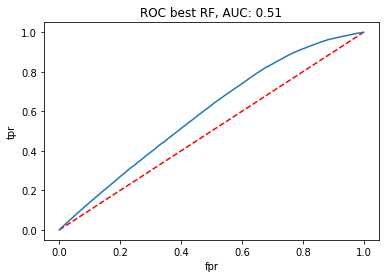

In [171]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

plt.clf()
plt.plot([0,1],[0,1], 'k--', c="red")
plt.plot(fpr, tpr)
plt.title("ROC best RF, AUC: {}".format(round(roc_auc_score(y_test, predicted_labels), 3)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

### Tabla de métricas

In [172]:
precision, recall, thresholds_2 = precision_recall_curve(y_test, y_scores)
thresholds_2 = np.append(thresholds_2, 1)

In [173]:
(precision.shape, recall.shape, thresholds_2.shape)

((3379,), (3379,), (3379,))

In [174]:
def get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2):
    df_1 = pd.DataFrame({
        'threshold': thresholds_2,
        'precision': precision, 
        'recall': recall})
    
    df_1['f1_score'] = 2 * (df_1.precision * df_1.recall) / (df_1.precision + df_1.recall)
    
    df_2 = pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'threshold': thresholds})
    
    df_2['tnr'] = 1 - df_2['fpr']
    df_2['fnr'] = 1 - df_2['tpr']
    
    df = df_1.merge(df_2, on="threshold")
    
    return df

In [175]:
metrics_report = get_metrics_report(fpr, tpr, thresholds, precision, recall, thresholds_2)
metrics_report

,threshold,precision,recall,f1_score,tpr,fpr,tnr,fnr
0,0.012637,0.195098,1.000000,0.326497,1.000000,0.999829,0.000171,0.000000
1,0.013152,0.195096,0.999988,0.326494,0.999988,0.999829,0.000171,0.000012
2,0.013180,0.195096,0.999988,0.326494,0.999988,0.999826,0.000174,0.000012
3,0.013276,0.195098,0.999975,0.326495,0.999975,0.999805,0.000195,0.000025
4,0.013834,0.195101,0.999975,0.326500,0.999975,0.999784,0.000216,0.000025
...,...,...,...,...,...,...,...,...
3134,0.294925,0.276316,0.009340,0.018069,0.009340,0.005928,0.994072,0.990660
3135,0.298499,0.276166,0.005411,0.010614,0.005411,0.003437,0.996563,0.994589
3136,0.302256,0.276341,0.005411,0.010615,0.005411,0.003434,0.996566,0.994589
3137,0.304941,0.283711,0.003249,0.006425,0.003249,0.001988,0.998012,0.996751


In [176]:
def pr_k_curve(y_labels, y_scores, k_target, save_target):
    k_values = list(np.arange(0.01, 1, 0.01))
    pr_k = pd.DataFrame()

    for k in k_values:
        d = dict()
        d['k'] = k
        d['precision'] = precision_at_k(y_labels, y_scores, k)
        d['recall'] = recall_at_k(y_labels, y_scores, k)

        pr_k = pr_k.append(d, ignore_index=True)

    # para la gráfica
    fig, ax1 = plt.subplots()
    ax1.plot(pr_k['k'], pr_k['precision'], label='precision')
    ax1.plot(pr_k['k'], pr_k['recall'], label='recall')
    
    # línea vertical
    plt.axvline(x=k_target, color='b', ls='--', label=f'k@{round(k_target, 2)}')
    plt.title('Curva precision-recall @k')    
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
    

    if save_target is not None:
        plt.savefig(save_target, dpi=300)

    return pr_k

,k,precision,recall
0,0.01,0.270555,0.015529
1,0.02,0.261191,0.027896
2,0.03,0.258745,0.039843
3,0.04,0.257125,0.055842
4,0.05,0.257706,0.067863
...,...,...,...
94,0.95,0.201743,0.982506
95,0.96,0.200418,0.986435
96,0.97,0.199121,0.990141
97,0.98,0.197819,0.993860


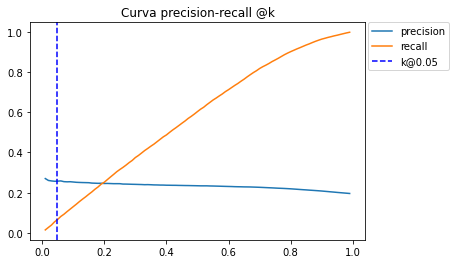

In [177]:
pr_k_curve(y_test, y_scores, k20, 'pr_rec_k_curve')

## Sesgo e inequidad

Utilizando el feature `delegacion` como atributo protegido:
1. Selecciona 3 métricas adecuadas de acuerdo a los objetivos y acciones. 
    * Dado que nuestro modelo es asistivo (mandamos ambulacias a personas para auxiliarlas en caso de pronosticar 0), seleccionamos las métricas: 
        * Recall Parity
        * FOR Parity
        * FNR Parity
1. Define cuál es tu grupo de referencia. Justifica. 
   * Utilizaremos la delegación de Iztapalapa ya que en los datos históricos del set es el grupo con mayor número de observaciones y también es el grupo al que mayor cantidad de ambulancias se han mandado como falsa alarma.
1. Cuantifica el sesgo e inequidad sobre los grupos de este atributo.

In [178]:
import seaborn as sns

from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

### Generando df de Aequitas

In [179]:
test_del_path = '../../output/test_df.pkl'
df_test_del = load_df(test_del_path)
df_test_del.head()

,fecha_creacion,hora_creacion,dia_semana,delegacion_inicio,incidente_c4,tipo_entrada,mes,label,sin_hr,cos_hr,sin_mes,cos_mes
1251176,2018-10-19,20:57:10,viernes,alvaro obregon,accidente-choque sin lesionados,llamada del 911,10,0,-0.866025,0.500000,-0.866025,0.5
1251177,2018-10-19,14:52:28,viernes,benito juarez,accidente-choque sin lesionados,llamada del 911,10,0,-0.500000,-0.866025,-0.866025,0.5
1251163,2018-10-19,15:28:27,viernes,cuauhtemoc,accidente-choque sin lesionados,llamada del 911,10,0,-0.707107,-0.707107,-0.866025,0.5
1251178,2018-10-19,20:21:12,viernes,iztapalapa,accidente-choque con lesionados,llamada del 911,10,0,-0.866025,0.500000,-0.866025,0.5
1251146,2018-10-19,23:36:55,viernes,coyoacan,accidente-choque con lesionados,llamada del 911,10,0,-0.258819,0.965926,-0.866025,0.5


In [180]:
df_test_del = crea_timestamp(df_test_del)
df_test_del.head()

,fecha_creacion,hora_creacion,dia_semana,delegacion_inicio,incidente_c4,tipo_entrada,mes,label,sin_hr,cos_hr,sin_mes,cos_mes,timestamp_creacion
1251176,2018-10-19,20:57:10,viernes,alvaro obregon,accidente-choque sin lesionados,llamada del 911,10,0,-0.866025,0.500000,-0.866025,0.5,2018-10-19 20:57:10
1251177,2018-10-19,14:52:28,viernes,benito juarez,accidente-choque sin lesionados,llamada del 911,10,0,-0.500000,-0.866025,-0.866025,0.5,2018-10-19 14:52:28
1251163,2018-10-19,15:28:27,viernes,cuauhtemoc,accidente-choque sin lesionados,llamada del 911,10,0,-0.707107,-0.707107,-0.866025,0.5,2018-10-19 15:28:27
1251178,2018-10-19,20:21:12,viernes,iztapalapa,accidente-choque con lesionados,llamada del 911,10,0,-0.866025,0.500000,-0.866025,0.5,2018-10-19 20:21:12
1251146,2018-10-19,23:36:55,viernes,coyoacan,accidente-choque con lesionados,llamada del 911,10,0,-0.258819,0.965926,-0.866025,0.5,2018-10-19 23:36:55


In [181]:
df_test_del = df_test_del.sort_values('timestamp_creacion', ascending=True, ignore_index=True)
df_test_del.head()

,fecha_creacion,hora_creacion,dia_semana,delegacion_inicio,incidente_c4,tipo_entrada,mes,label,sin_hr,cos_hr,sin_mes,cos_mes,timestamp_creacion
0,2018-10-19,00:02:01,viernes,tlalpan,accidente-choque con lesionados,llamada del 911,10,0,0.0,1.0,-0.866025,0.5,2018-10-19 00:02:01
1,2018-10-19,00:12:45,viernes,cuauhtemoc,accidente-choque sin lesionados,llamada del 911,10,0,0.0,1.0,-0.866025,0.5,2018-10-19 00:12:45
2,2018-10-19,00:18:43,viernes,coyoacan,accidente-choque sin lesionados,llamada del 911,10,0,0.0,1.0,-0.866025,0.5,2018-10-19 00:18:43
3,2018-10-19,00:18:52,viernes,coyoacan,accidente-choque sin lesionados,llamada del 911,10,0,0.0,1.0,-0.866025,0.5,2018-10-19 00:18:52
4,2018-10-19,00:29:13,viernes,tlalpan,accidente-choque sin lesionados,zello,10,1,0.0,1.0,-0.866025,0.5,2018-10-19 00:29:13


In [182]:
(df_test_del.shape[0], x_test.shape[0])

(414941, 414941)

In [183]:
aequitas_df = pd.DataFrame()
aequitas_df['score'] = y_scores
aequitas_df['label_value'] = y_test
aequitas_df['delegacion'] = df_test_del.delegacion_inicio
aequitas_df.head()

,score,label_value,delegacion
0,0.204313,0,tlalpan
1,0.204313,0,cuauhtemoc
2,0.204313,0,coyoacan
3,0.204313,0,coyoacan
4,0.049878,1,tlalpan


### Obteniendo métricas de interés

In [184]:
g = Group()
xtab, attrbs = g.get_crosstabs(aequitas_df)

model_id, score_thresholds 0 {'rank_abs': [0]}


In [185]:
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,...,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,0,delegacion,alvaro obregon,0.0,1.0,0.214863,NaN,0.0,...,0.0,0,6439,23529,0,6439,23529,29968,414941,0.214863
1,0,binary 0/1,0,delegacion,azcapotzalco,0.0,1.0,0.154190,NaN,0.0,...,0.0,0,2793,15321,0,2793,15321,18114,414941,0.154190
2,0,binary 0/1,0,delegacion,benito juarez,0.0,1.0,0.154150,NaN,0.0,...,0.0,0,4807,26377,0,4807,26377,31184,414941,0.154150
3,0,binary 0/1,0,delegacion,coyoacan,0.0,1.0,0.213620,NaN,0.0,...,0.0,0,6766,24907,0,6766,24907,31673,414941,0.213620
4,0,binary 0/1,0,delegacion,cuajimalpa,0.0,1.0,0.316280,NaN,0.0,...,0.0,0,2479,5359,0,2479,5359,7838,414941,0.316280
5,0,binary 0/1,0,delegacion,cuauhtemoc,0.0,1.0,0.140629,NaN,0.0,...,0.0,0,5843,35706,0,5843,35706,41549,414941,0.140629
6,0,binary 0/1,0,delegacion,gustavo a. madero,0.0,1.0,0.185474,NaN,0.0,...,0.0,0,7666,33666,0,7666,33666,41332,414941,0.185474
7,0,binary 0/1,0,delegacion,iztacalco,0.0,1.0,0.185795,NaN,0.0,...,0.0,0,3241,14203,0,3241,14203,17444,414941,0.185795
8,0,binary 0/1,0,delegacion,iztapalapa,0.0,1.0,0.219187,NaN,0.0,...,0.0,0,15175,54058,0,15175,54058,69233,414941,0.219187
9,0,binary 0/1,0,delegacion,magdalena contreras,0.0,1.0,0.265251,NaN,0.0,...,0.0,0,1761,4878,0,1761,4878,6639,414941,0.265251


In [186]:
attrbs

Index(['delegacion'], dtype='object')

In [187]:
absolute_metrics = g.list_absolute_metrics(xtab)

In [188]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,0,delegacion,alvaro obregon,0,29968,0,6439,23529,0,6439,23529,29968,414941
1,0,binary 0/1,0,delegacion,azcapotzalco,0,18114,0,2793,15321,0,2793,15321,18114,414941
2,0,binary 0/1,0,delegacion,benito juarez,0,31184,0,4807,26377,0,4807,26377,31184,414941
3,0,binary 0/1,0,delegacion,coyoacan,0,31673,0,6766,24907,0,6766,24907,31673,414941
4,0,binary 0/1,0,delegacion,cuajimalpa,0,7838,0,2479,5359,0,2479,5359,7838,414941
5,0,binary 0/1,0,delegacion,cuauhtemoc,0,41549,0,5843,35706,0,5843,35706,41549,414941
6,0,binary 0/1,0,delegacion,gustavo a. madero,0,41332,0,7666,33666,0,7666,33666,41332,414941
7,0,binary 0/1,0,delegacion,iztacalco,0,17444,0,3241,14203,0,3241,14203,17444,414941
8,0,binary 0/1,0,delegacion,iztapalapa,0,69233,0,15175,54058,0,15175,54058,69233,414941
9,0,binary 0/1,0,delegacion,magdalena contreras,0,6639,0,1761,4878,0,1761,4878,6639,414941


In [189]:
xtab[['attribute_name', 'attribute_value']+[col for col in xtab.columns if col in absolute_metrics]].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,delegacion,alvaro obregon,0.0,1.0,0.21,NaN,0.0,1.0,0.79,NaN,NaN,0.0,0.21
1,delegacion,azcapotzalco,0.0,1.0,0.15,NaN,0.0,1.0,0.85,NaN,NaN,0.0,0.15
2,delegacion,benito juarez,0.0,1.0,0.15,NaN,0.0,1.0,0.85,NaN,NaN,0.0,0.15
3,delegacion,coyoacan,0.0,1.0,0.21,NaN,0.0,1.0,0.79,NaN,NaN,0.0,0.21
4,delegacion,cuajimalpa,0.0,1.0,0.32,NaN,0.0,1.0,0.68,NaN,NaN,0.0,0.32
5,delegacion,cuauhtemoc,0.0,1.0,0.14,NaN,0.0,1.0,0.86,NaN,NaN,0.0,0.14
6,delegacion,gustavo a. madero,0.0,1.0,0.19,NaN,0.0,1.0,0.81,NaN,NaN,0.0,0.19
7,delegacion,iztacalco,0.0,1.0,0.19,NaN,0.0,1.0,0.81,NaN,NaN,0.0,0.19
8,delegacion,iztapalapa,0.0,1.0,0.22,NaN,0.0,1.0,0.78,NaN,NaN,0.0,0.22
9,delegacion,magdalena contreras,0.0,1.0,0.27,NaN,0.0,1.0,0.73,NaN,NaN,0.0,0.27


In [190]:
aeq = Plot()

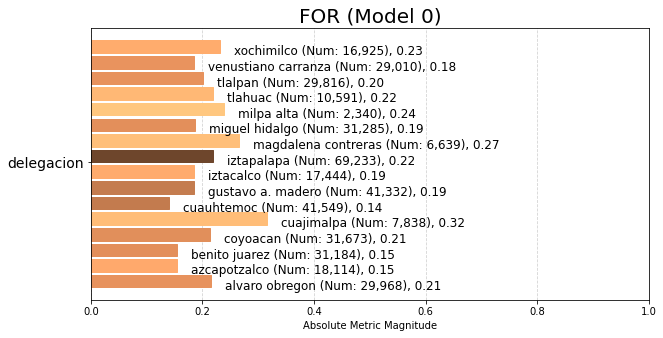

In [191]:
metric_for = aeq.plot_group_metric(xtab, 'for')

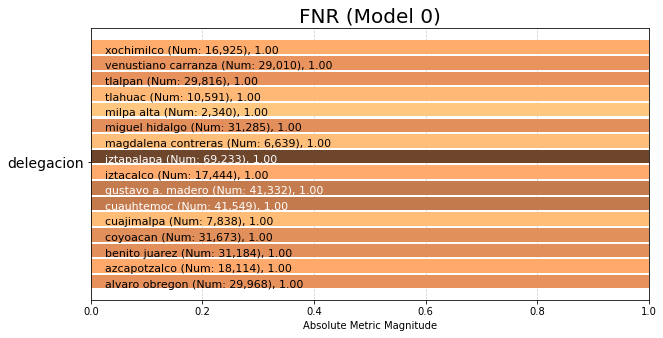

In [192]:
metric_fnr = aeq.plot_group_metric(xtab, 'fnr')

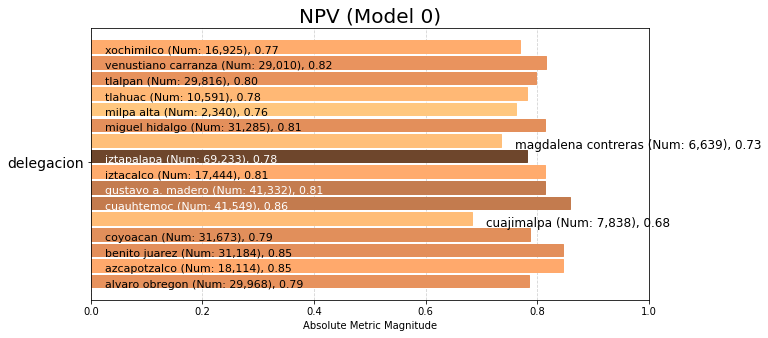

In [193]:
metric_npv = aeq.plot_group_metric(xtab, 'npv')

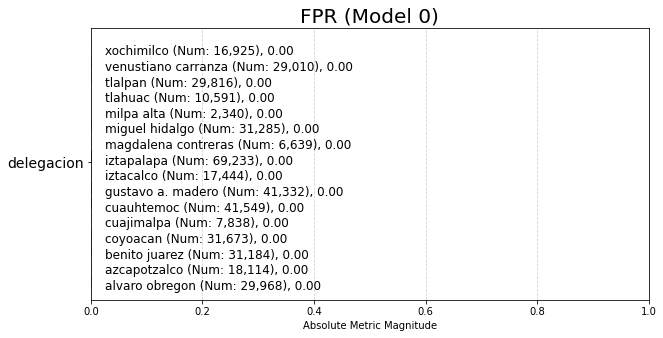

In [194]:
metric_fpr = aeq.plot_group_metric(xtab, 'fpr')

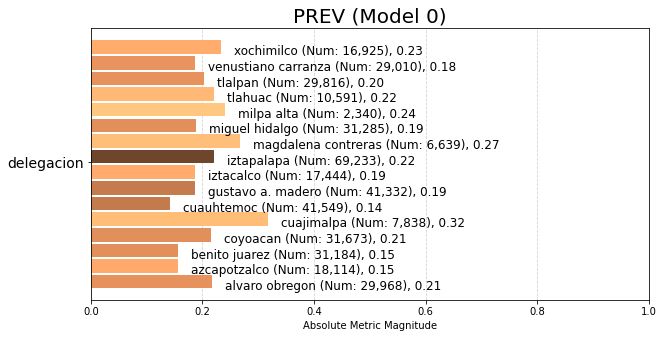

In [195]:
metric_prev = aeq.plot_group_metric(xtab, 'prev')

### Bias

In [196]:
bias = Bias()

In [197]:
bdf = bias.get_disparity_major_group(df=xtab, original_df=aequitas_df, alpha=0.05)

get_disparity_major_group()


In [198]:
bdf[['attribute_name', 'attribute_value'] + bias.list_disparities(bdf)].round(2)

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,delegacion,alvaro obregon,NaN,NaN,NaN,NaN,0.98,NaN,1.0,NaN,1.0,1.01
1,delegacion,azcapotzalco,NaN,NaN,NaN,NaN,0.70,NaN,1.0,NaN,1.0,1.08
2,delegacion,benito juarez,NaN,NaN,NaN,NaN,0.70,NaN,1.0,NaN,1.0,1.08
3,delegacion,coyoacan,NaN,NaN,NaN,NaN,0.97,NaN,1.0,NaN,1.0,1.01
4,delegacion,cuajimalpa,NaN,NaN,NaN,NaN,1.44,NaN,1.0,NaN,1.0,0.88
5,delegacion,cuauhtemoc,NaN,NaN,NaN,NaN,0.64,NaN,1.0,NaN,1.0,1.10
6,delegacion,gustavo a. madero,NaN,NaN,NaN,NaN,0.85,NaN,1.0,NaN,1.0,1.04
7,delegacion,iztacalco,NaN,NaN,NaN,NaN,0.85,NaN,1.0,NaN,1.0,1.04
8,delegacion,iztapalapa,NaN,NaN,NaN,NaN,1.00,NaN,1.0,NaN,1.0,1.00
9,delegacion,magdalena contreras,NaN,NaN,NaN,NaN,1.21,NaN,1.0,NaN,1.0,0.94


In [199]:
metrics = ['for_disparity', 'fnr_disparity', 'tnr_disparity', 'npv_disparity']
bdf[['attribute_name', 'attribute_value'] + metrics].round(2)

,attribute_name,attribute_value,for_disparity,fnr_disparity,tnr_disparity,npv_disparity
0,delegacion,alvaro obregon,0.98,1.0,1.0,1.01
1,delegacion,azcapotzalco,0.70,1.0,1.0,1.08
2,delegacion,benito juarez,0.70,1.0,1.0,1.08
3,delegacion,coyoacan,0.97,1.0,1.0,1.01
4,delegacion,cuajimalpa,1.44,1.0,1.0,0.88
5,delegacion,cuauhtemoc,0.64,1.0,1.0,1.10
6,delegacion,gustavo a. madero,0.85,1.0,1.0,1.04
7,delegacion,iztacalco,0.85,1.0,1.0,1.04
8,delegacion,iztapalapa,1.00,1.0,1.0,1.00
9,delegacion,magdalena contreras,1.21,1.0,1.0,0.94


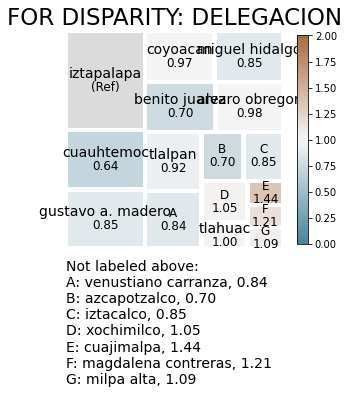

In [200]:
for_disparity = aeq.plot_disparity(bdf, 
                                   group_metric='for_disparity', 
                                   attribute_name='delegacion', 
                                   significance_alpha=0.05)

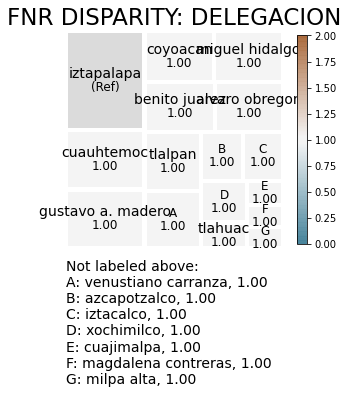

In [201]:
fnr_disparity = aeq.plot_disparity(bdf, 
                                   group_metric='fnr_disparity', 
                                   attribute_name='delegacion', 
                                   significance_alpha=0.05)

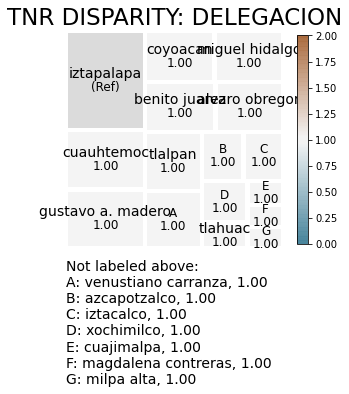

In [202]:
tnr_disparity = aeq.plot_disparity(bdf, 
                                   group_metric='tnr_disparity', 
                                   attribute_name='delegacion', 
                                   significance_alpha=0.05)

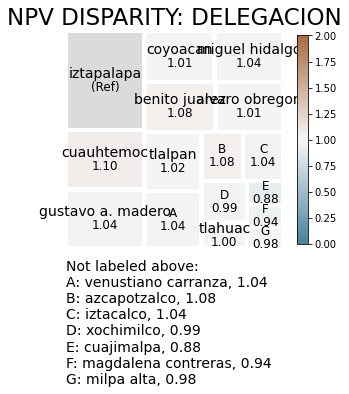

In [203]:
npv_disparity = aeq.plot_disparity(bdf, 
                                   group_metric='npv_disparity', 
                                   attribute_name='delegacion', 
                                   significance_alpha=0.05)

### Fairness

In [204]:
fair = Fairness()

In [205]:
fdf = fair.get_group_value_fairness(bdf)

In [206]:
parity_determinations = fair.list_parities(fdf)

In [207]:
fdf[['attribute_name', 'attribute_value'] 
    + absolute_metrics 
    + bias.list_disparities(fdf) 
    + parity_determinations].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,...,Precision Parity,TypeII Parity,Supervised Fairness,Equalized Odds,TPR Parity,Statistical Parity,TNR Parity,Impact Parity,FOR Parity,FNR Parity
0,delegacion,alvaro obregon,0.0,1.0,0.21,NaN,0.0,1.0,0.79,NaN,...,NaN,True,False,NaN,NaN,NaN,True,NaN,True,True
1,delegacion,azcapotzalco,0.0,1.0,0.15,NaN,0.0,1.0,0.85,NaN,...,NaN,False,False,NaN,NaN,NaN,True,NaN,False,True
2,delegacion,benito juarez,0.0,1.0,0.15,NaN,0.0,1.0,0.85,NaN,...,NaN,False,False,NaN,NaN,NaN,True,NaN,False,True
3,delegacion,coyoacan,0.0,1.0,0.21,NaN,0.0,1.0,0.79,NaN,...,NaN,True,False,NaN,NaN,NaN,True,NaN,True,True
4,delegacion,cuajimalpa,0.0,1.0,0.32,NaN,0.0,1.0,0.68,NaN,...,NaN,False,False,NaN,NaN,NaN,True,NaN,False,True
5,delegacion,cuauhtemoc,0.0,1.0,0.14,NaN,0.0,1.0,0.86,NaN,...,NaN,False,False,NaN,NaN,NaN,True,NaN,False,True
6,delegacion,gustavo a. madero,0.0,1.0,0.19,NaN,0.0,1.0,0.81,NaN,...,NaN,True,False,NaN,NaN,NaN,True,NaN,True,True
7,delegacion,iztacalco,0.0,1.0,0.19,NaN,0.0,1.0,0.81,NaN,...,NaN,True,False,NaN,NaN,NaN,True,NaN,True,True
8,delegacion,iztapalapa,0.0,1.0,0.22,NaN,0.0,1.0,0.78,NaN,...,NaN,True,False,NaN,NaN,NaN,True,NaN,True,True
9,delegacion,magdalena contreras,0.0,1.0,0.27,NaN,0.0,1.0,0.73,NaN,...,NaN,True,False,NaN,NaN,NaN,True,NaN,True,True


In [208]:
gaf = fair.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,delegacion,NaN,NaN,NaN,NaN,False,True,NaN,True,True,NaN,NaN,False,NaN,NaN,False


In [209]:
gof = fair.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': True,
 'Supervised Fairness': False,
 'Overall Fairness': False}

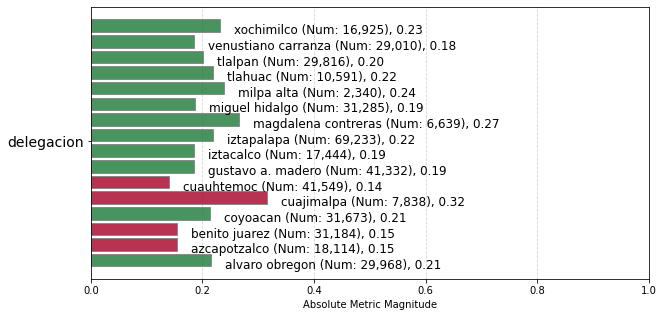

In [210]:
aeq.plot_fairness_group(fdf, group_metric='for');

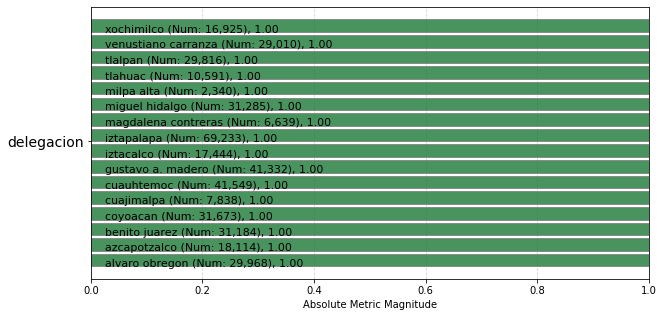

In [211]:
aeq.plot_fairness_group(fdf, group_metric='fnr');

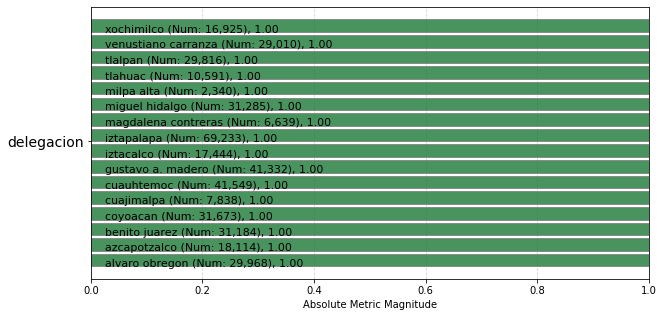

In [212]:
aeq.plot_fairness_group(fdf, group_metric='tnr');

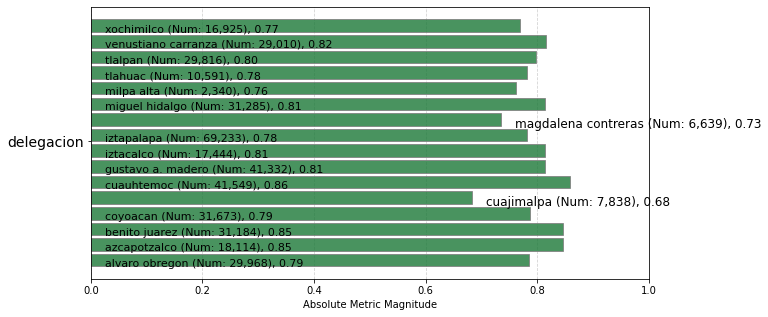

In [213]:
aeq.plot_fairness_group(fdf, group_metric='npv');